In [2]:
import numpy as np
from control import matlab
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

## 13.2　制御対象の解析

In [3]:
# 問題設定
A = np.array(pd.read_csv("./data/cartpole_model/sys_A.csv",header=None))
B = np.array(pd.read_csv("./data/cartpole_model/sys_B.csv",header=None))
D =0

- なにはともあれ可制御性判別

In [4]:
Uc = matlab.ctrb(A, B)
Rc = np.linalg.matrix_rank(Uc)

In [6]:
print("ランク:",Rc,"サイズ:",min(Uc.shape))

ランク: 4 サイズ: 4


- 次は安定性を見よう

In [7]:
#元の極を見てみる
np.linalg.eig(A)[0]

array([ 0. ,  0. ,  4.4, -4.4])

In [9]:
def show_eig(A):
    plt.figure()
    plt.scatter(np.real(np.linalg.eigvals(A)), np.imag(np.linalg.eigvals(A)))
    plt.axhline(0,-120,5,color="gray")
    plt.axvline(0,-20,20,color="gray")
    plt.show()

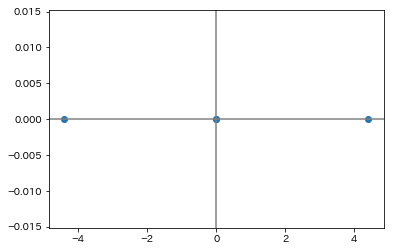

In [10]:
show_eig(A)

- 実部正の固有値を含むので、このままじゃ不安定！

- 次は２つの観測行列の可観測性を比較する

In [11]:
C1 = np.array([1, 0, 0, 0])
C2 = np.array([0, 1, 0, 0])

In [12]:
Uo1 = matlab.obsv(A, C1)
Ro1 = np.linalg.matrix_rank(Uo1)
print("ランク:",Ro1,"サイズ:",min(Uo1.shape))

ランク: 4 サイズ: 4


In [13]:
Uo2 = matlab.obsv(A, C2)
Ro2 = np.linalg.matrix_rank(Uo2)
print("ランク:",Ro2,"サイズ:",min(Uo2.shape))

ランク: 2 サイズ: 4


- C1だったら可観測だけどC2は不可観測になる

- C1を採用して、次はサーボ系が構成可能か調べる

In [17]:
M = np.block([[A, B],[C1, 0]])
np.linalg.eigvals(M)

array([ 4.40276971+0.j        , -4.39730343+0.j        ,
        1.06636093+0.j        , -0.5359136 +0.92525428j,
       -0.5359136 -0.92525428j])

- $M(0) = \left(
    \begin{array}{cc}
      A & B \\
      -C & 0 
    \end{array}
  \right)$
  の固有値に0が入ってないのでサーボ系設計可能

## 13.3 制御系の設計
- まずは状態フィードバックゲイン

In [19]:
Q = np.diag([10]*4)
R1 = 10
R2 = 0.1

In [22]:
F1, X1, E1 = matlab.lqr(A, B, Q, R1) #ここでリカッチ方程式を解いてる
F2, X2, E2 = matlab.lqr(A, B, Q, R2) #ここでリカッチ方程式を解いてる

In [23]:
print(F1, F2)

[[ -1.         -24.64260173  -2.09565197  -5.76696571]] [[-10.         -89.01499274 -16.29019651 -23.08194791]]


- 続いてオブザーバーゲイン

In [34]:
A_star = A.T
B_star = C1.T.reshape(-1,1)

- 極配置法で極を移動

In [38]:
poles1 = [-0.8+0.5j, -0.8-0.5j, -0.7, -0.5]
poles2 = [-13+1j, -13-1j, -12, -10]
F_star1 = matlab.place(A_star, B_star, poles1)
F_star2 = matlab.place(A_star, B_star, poles2)
L_1 = F_star1.T
L_2 = F_star2.T

In [39]:
print(L_1,L_2)

[[   2.8       ]
 [ -65.68941176]
 [  22.52      ]
 [-513.29258823]] [[    48.        ]
 [ -9163.85882297]
 [   881.35999996]
 [-44074.27011471]]
